# TP 2

#### Grupo 4: Aschieri Juan Pablo, Civini Diego Emanuel, Rivero Joaquin, Rovira Rossel Francisco

In [82]:
from math import e, log
import time
from heapq import heappush, heappop
from scipy.stats import poisson
import matplotlib.pyplot as plt
import itertools
import simpy
import numpy as np
import random

In [8]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [9]:
class Uniform_generator:
    def __init__(self, seed, scale= 1, displacement= 0):
        self.xorshift_genertor = Xorshift_generator(seed)
        self.scale = scale
        self.displacement = displacement

    def rand(self):
        n = self.xorshift_genertor.rand() / ((2**32)-1)
        return n * self.scale + self.displacement
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [10]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        return log(r/self.parameter)/(-1*self.parameter)
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

## Ejercicio 1

In [183]:
def factorial(n):
    resultado = 1
    for i in range(1, n + 1):
        resultado *= i
    return resultado

def poisson_probability(parameter, i, previous_probability):
    if previous_probability == 0:
        return poisson.pmf(i, parameter)
    return (parameter/i)*previous_probability

class Poisson_generator:
    def __init__(self, seed, parameter):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()

        accumulated_probability = poisson_probability(self.parameter, 0, 0)
        previous_probability = accumulated_probability
        i = 0

        while(accumulated_probability < r):
            i += 1
            previous_probability = poisson_probability(self.parameter, i, previous_probability)
            accumulated_probability += previous_probability

        return i
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Asumimos que el satélite da la vuelta al mundo en 24 horas y que llegan un promedio de 10 solicitudes de imagenes por dia (como el tiempo entre solicitudes de imágenes se modelan como tiempos exponenciales de parámetro 10, el proceso de poisson obtenido tiene media 10)

In [184]:
def simulate_satelite_request_queue_length(time_step, iterations, request_per_unit_time, satelite_period):
    generator_amount_of_request = Poisson_generator(int(time.time()) * 8647359734, request_per_unit_time*time_step)
    generator_time_to_serve = Uniform_generator(int(time.time()) * 345678976, satelite_period)
    simulated_queue = []
    observed_queue_length = {}

    for _ in range(iterations):
        advance_time(simulated_queue, time_step)
        get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve)    
        observed_queue_length[len(simulated_queue)] = observed_queue_length.get(len(simulated_queue), 0) + 1

    return get_frequencies(observed_queue_length, iterations)

In [185]:
def advance_time(simulated_queue, time_step):
    for i in range(len(simulated_queue)):
        simulated_queue[i] -= time_step

    while (len(simulated_queue) != 0 and simulated_queue[0] <= 0):
        item = heappop(simulated_queue)
        #print(f'Se elimino una request de tiempo: {item}')

def get_acumulated_requests(generator_amount_of_request, simulated_queue, generator_time_to_serve):
    amount_of_requests = generator_amount_of_request.rand()
    for request in range(amount_of_requests):
        #por ahora asumimos que el time to serve es uniforme, porque se hacen requests uniformemente alrededor del mundo
        heappush(simulated_queue, generator_time_to_serve.rand())

def get_frequencies(observed_queue_length, iterations):
    #print(f'Entro a get_frequencies con dicc = {observed_queue_length}')
    observed_frequencies = []
    #print(f'El maximo es: {max(observed_queue_length.keys())}')
    for j in range(max(observed_queue_length.keys()) + 1):
        times_observed = observed_queue_length.get(j, 0)
        #print(f'Para {j} se observo {times_observed}')
        observed_frequencies.append(times_observed/iterations)
    return observed_frequencies

In [186]:
l = simulate_satelite_request_queue_length(0.5, 100000, 5/12, 48)

In [187]:
len(l)

26

In [188]:
#l[10]

In [189]:
aux = 0
for i in l:
    aux += i

In [190]:
aux

1.0

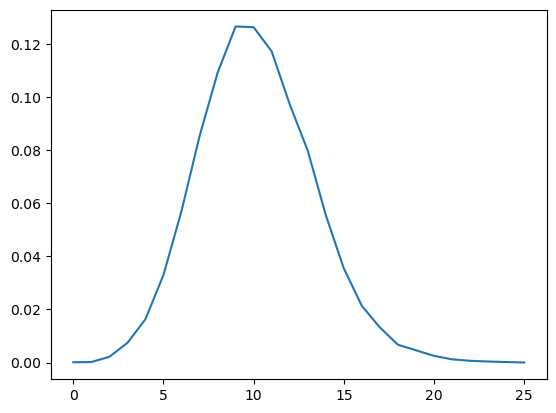

In [191]:
x_axis = list(range(len(l)))
y_axis = l
plt.plot(x_axis, y_axis)
plt.show()

## Ejercicio 2

In [94]:
BUFFER_SIZE = 100
SIM_TIME = 100

De esta manera cada maquina es un proceso y desp hay otro proceso que se encarga de llenar las lista con requests para que cada maquina vaya desencolando 
y procesando requests

In [96]:
"""
Con esta implementacion, las maquinas chequean que haya requests en la cola cada 1 seg. Osea, que si la cola estaa vacia, la maquina cada 1 seg va a 
chequear si llego un nuevo mensaje. Ver con los chicos si estan de acuerdo con esto (o tamb preguntar al de la practica). Porque otro caso que CREO que se puede
hacer es que apenas llegue un request, la maquina ya sepa y lo empieze a procesar all instante.
Tambien ver que onda el arrribo de mensajes, estan llegando cada mucho tiempo y los procesa re rapido entonces la cola siempre esta vacia
"""
def request_generator(env, requests_center, requests_buffer, seed):
    """Las solicitudes llegan siguiendo un proceso Poisson con una frecuencia media de 10
    por minuto. Por ende el tiempo entre 2 solicitudes consecutivas seguira una distribucion
    Exponencial de paremtro 10."""
    # exponential_gen = Exp_generator(seed, 1/6) # We turn the 10 minutes into seconds TO-DO: VER QUUE CON NUESTRO GEN ME DA NUMERO NEGATIVOS
    print("Requests start to arrive")
    for i in itertools.count():
        #time_for_next_request = exponential_gen.rand()
        time_for_next_request = np.random.exponential(6) # El parametro en esta lib tiene que ser b=1/lambda
        print(f"The next request will arrive in {time_for_next_request}, we are at {env.now}")
        yield env.timeout(time_for_next_request)
        with requests_center.request() as req:
            yield req
            if requests_buffer.level == BUFFER_SIZE:
                print(f"The buffer is full and cannot accept more requests. This requests has been dropped at time {env.now}")
            else:
                print(f"A request arrived and was buffered at time {env.now}")
                yield requests_buffer.put(1)
    print("Requests will stop to arrive")

def processing_machine(env, requests_center, requests_buffer, seed, machine_id):
    #exponential_gen = Exp_generator(seed, 10) TO-DO: VER QUUE CON NUESTRO GEN ME DA NUMERO NEGATIVOS
    print(f"The machine {machine_id} starts.")
    while True:
        time_to_process = 1
        request_processed = False
        print(f"The machine {machine_id} will try to process a request at {env.now}")
        with requests_center.request() as req:
            yield req
            if requests_buffer.level != 0:
                print(f"A request is starting to be processed by machine {machine_id} at {env.now}")
                yield requests_buffer.get(1)
                print(f"La cantidad de requests en el buffer es {requests_buffer.level}")
                #time_to_process = exponential_gen.rand()
                time_to_process = np.random.exponential(1/10)
                request_processed = True
        # If there are no requests to process in the buffer, the timeout is of 0 seconds.
        yield env.timeout(time_to_process)
        if request_processed:
            print(f"Machine {machine_id} has finished processing the request at {env.now}")

In [97]:
env = simpy.Environment()
requests_center = simpy.Resource(env, 1)
requests_buffer = simpy.Container(env, BUFFER_SIZE, init=0)
env.process(request_generator(env, requests_center, requests_buffer, int(time.time())))
env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()), 1))
#env.process(processing_machine(env, requests_center, requests_buffer, int(time.time()), 2))

env.run(until=SIM_TIME)

Requests start to arrive
The next request will arrive in 0.09182432811484767, we are at 0
The machine 1 starts.
The machine 1 will try to process a request at 0
A request arrived and was buffered at time 0.09182432811484767
The next request will arrive in 8.192610028995942, we are at 0.09182432811484767
The machine 1 will try to process a request at 1
A request is starting to be processed by machine 1 at 1
La cantidad de requests en el buffer es 0
Machine 1 has finished processing the request at 1.005153034308511
The machine 1 will try to process a request at 1.005153034308511
The machine 1 will try to process a request at 2.005153034308511
The machine 1 will try to process a request at 3.005153034308511
The machine 1 will try to process a request at 4.0051530343085116
The machine 1 will try to process a request at 5.0051530343085116
The machine 1 will try to process a request at 6.0051530343085116
The machine 1 will try to process a request at 7.0051530343085116
The machine 1 will try

De estas otra manera, cada requests va a ser un proceso y las maquinas van a ser los recursos

In [ ]:
random.seed(22)

env = simpy.Environment()
processing_center = simpy.Resource(env, 2)

env.process(gas_station_control(env, fuel_pump))
env.process(car_generator(env, gas_station, fuel_pump))